In [1]:
from __future__ import annotations

from typing import Any

import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
from IPython.display import display as ipy_display

import torch
import transformers
from transformers import DistilBertForSequenceClassification
from transformers import DistilBertTokenizer
from transformers import Trainer
from transformers import TrainingArguments
from transformers.trainer_utils import EvalPrediction

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

%config InlineBackend.figure_format = 'svg'

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"Using device: {device}", end="\n\n")
print(f"Torch version: {torch.__version__}")

Using device: cuda

Torch version: 1.13.1+cu116


In [3]:
def encode_labels(df: pd.DataFrame, y_column: str) -> tuple[pd.DataFrame, dict]:
    """Encode labels to be used by the classifier."""
    enc = LabelEncoder()
    enc.fit(df[y_column])
    encoded_labels = dict(zip(enc.classes_, enc.transform(enc.classes_))) # will use that in the cm later
    df['label'] = enc.transform(df['label'])
    return df, encoded_labels

In [4]:
class RedditDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['label'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


def compute_metrics(eval_pred: EvalPrediction) -> dict[str, Any]:
    """Compute metrics for the model."""
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {
        'accuracy': accuracy_score(labels, predictions),
        'precision': precision_score(labels, predictions, average='macro'),
        'recall': recall_score(labels, predictions, average='macro'),
        'f1': f1_score(labels, predictions, average='macro'),
    }

In [5]:
RAW_DATA_FILE = "../../data/reddit_ell_eng_raw_pos.csv"

MARKERS = ['o', 's', 'v', 'p', 'x', 'd', 'h', '8', 'P', '*']
COLORS  = ['#404080', '#a52040', '#7d7dfa', '#d7d7d7', '#ff7f0e',
           '#2ca02c', '#1f77b4', '#9467bd', '#8c564b', '#e377c2']

PARMS = {
    'batch_size': 32,
    'epochs': 50,
    'learning_rate': 2e-5,
    'seed': 42,
    'max_length': 512,
}

all_results = pd.DataFrame()

In [6]:
df = pd.read_csv(RAW_DATA_FILE, encoding='utf-8')

df, labels = encode_labels(df, 'label')

X = df['text']
y = df['label']

gss_1 = GroupShuffleSplit(n_splits=2, test_size=0.2)
train_idx, test_idx = next(gss_1.split(X, y, groups=df['user_id']))
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

gss_2 = GroupShuffleSplit(n_splits=2, test_size=0.5)
val_idx, test_idx = next(gss_2.split(X_test, y_test, groups=df['user_id'].iloc[test_idx]))
X_val, X_test = X_test.iloc[val_idx], X_test.iloc[test_idx]
y_val, y_test = y_test.iloc[val_idx], y_test.iloc[test_idx]

print(f"{X_train.shape=}, {X_test.shape=}")
print(f"{y_train.shape=}, {y_test.shape=}")
print(f"{X_val.shape=}, {y_val.shape=}", end="\n\n")

X_train.shape=(7215,), X_test.shape=(1498,)
y_train.shape=(7215,), y_test.shape=(1498,)
X_val.shape=(1211,), y_val.shape=(1211,)



In [7]:
model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = transformers.DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=len(labels))

train_encodings = tokenizer(X_train.tolist(), truncation=True, padding=True)
test_encodings = tokenizer(X_test.tolist(), truncation=True, padding=True)
val_encodings = tokenizer(X_val.tolist(), truncation=True, padding=True)

train_dataset = RedditDataset(train_encodings, y_train.tolist())
test_dataset = RedditDataset(test_encodings, y_test.tolist())
val_dataset = RedditDataset(val_encodings, y_val.tolist())


# add dropout and early stopping
model.config.dropout = 0.75
early_stopping = transformers.EarlyStoppingCallback(early_stopping_patience=5)

training_args = transformers.TrainingArguments(
    output_dir=f'../results/reports/{model_name}',
    num_train_epochs=PARMS['epochs'],
    learning_rate=PARMS['learning_rate'],
    per_device_train_batch_size=PARMS['batch_size'],
    per_device_eval_batch_size=PARMS['batch_size'],
    evaluation_strategy='epoch',
    weight_decay=0.01,
    warmup_steps=500,
    logging_dir='./logs/distilbert',
    logging_steps=len(train_dataset) // PARMS['batch_size'],
    log_level='error',
    disable_tqdm=False,
    seed=PARMS['seed'],
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='f1',
)

trainer = transformers.Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    callbacks=[early_stopping],
)

trainer.train()    
trainer.evaluate()
trainer.state.save_to_json(f'../results/reports/{model_name}/trainer_state.json')

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'classifier

  0%|          | 0/11300 [00:00<?, ?it/s]

{'loss': 0.5815, 'learning_rate': 9e-06, 'epoch': 1.0}


  0%|          | 0/38 [00:00<?, ?it/s]

{'eval_loss': 0.46054133772850037, 'eval_accuracy': 0.8001651527663088, 'eval_precision': 0.8084084989128797, 'eval_recall': 0.7526541337471784, 'eval_f1': 0.7666406548604918, 'eval_runtime': 10.8951, 'eval_samples_per_second': 111.151, 'eval_steps_per_second': 3.488, 'epoch': 1.0}
{'loss': 0.4057, 'learning_rate': 1.8e-05, 'epoch': 1.99}


  0%|          | 0/38 [00:00<?, ?it/s]

{'eval_loss': 0.4589703679084778, 'eval_accuracy': 0.7910817506193228, 'eval_precision': 0.7767578077308133, 'eval_recall': 0.7665082416290443, 'eval_f1': 0.7708293908166599, 'eval_runtime': 10.9808, 'eval_samples_per_second': 110.284, 'eval_steps_per_second': 3.461, 'epoch': 2.0}
{'loss': 0.3336, 'learning_rate': 1.967592592592593e-05, 'epoch': 2.99}


  0%|          | 0/38 [00:00<?, ?it/s]

{'eval_loss': 0.5420355200767517, 'eval_accuracy': 0.7588769611890999, 'eval_precision': 0.7427861340658846, 'eval_recall': 0.7535359057562077, 'eval_f1': 0.746361967062604, 'eval_runtime': 11.8373, 'eval_samples_per_second': 102.304, 'eval_steps_per_second': 3.21, 'epoch': 3.0}
{'loss': 0.2382, 'learning_rate': 1.925925925925926e-05, 'epoch': 3.98}


  0%|          | 0/38 [00:00<?, ?it/s]

{'eval_loss': 0.576991617679596, 'eval_accuracy': 0.781998348472337, 'eval_precision': 0.7685456962946238, 'eval_recall': 0.7517047592174568, 'eval_f1': 0.7580492825573653, 'eval_runtime': 11.0647, 'eval_samples_per_second': 109.447, 'eval_steps_per_second': 3.434, 'epoch': 4.0}
{'loss': 0.1425, 'learning_rate': 1.8842592592592594e-05, 'epoch': 4.98}


  0%|          | 0/38 [00:00<?, ?it/s]

{'eval_loss': 0.7470672726631165, 'eval_accuracy': 0.7753922378199835, 'eval_precision': 0.7592657107582481, 'eval_recall': 0.7493621849134687, 'eval_f1': 0.7534860050890585, 'eval_runtime': 10.8535, 'eval_samples_per_second': 111.577, 'eval_steps_per_second': 3.501, 'epoch': 5.0}
{'loss': 0.0994, 'learning_rate': 1.8425925925925926e-05, 'epoch': 5.97}


  0%|          | 0/38 [00:00<?, ?it/s]

{'eval_loss': 0.7418561577796936, 'eval_accuracy': 0.7910817506193228, 'eval_precision': 0.7811446678713778, 'eval_recall': 0.7579109645410083, 'eval_f1': 0.7660671677973283, 'eval_runtime': 10.9862, 'eval_samples_per_second': 110.23, 'eval_steps_per_second': 3.459, 'epoch': 6.0}
{'loss': 0.0707, 'learning_rate': 1.800925925925926e-05, 'epoch': 6.97}


  0%|          | 0/38 [00:00<?, ?it/s]

{'eval_loss': 1.0523895025253296, 'eval_accuracy': 0.7836498761354252, 'eval_precision': 0.7688422843525047, 'eval_recall': 0.7573054810948081, 'eval_f1': 0.762031836891433, 'eval_runtime': 10.9553, 'eval_samples_per_second': 110.54, 'eval_steps_per_second': 3.469, 'epoch': 7.0}
{'train_runtime': 1359.5418, 'train_samples_per_second': 265.347, 'train_steps_per_second': 8.312, 'train_loss': 0.2664930972867609, 'epoch': 7.0}


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

y_pred_metrics:


,test_loss,test_accuracy,test_precision,test_recall,test_f1,test_runtime,test_samples_per_second,test_steps_per_second
0,0.295841,0.862483,0.833967,0.86477,0.845397,13.5857,110.263,3.46


Log history:


,loss,learning_rate,epoch,step,eval_loss,eval_accuracy,eval_precision,eval_recall,eval_f1,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,0.5815,0.000009,1.00,225,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,1.00,226,0.460541,0.800165,0.808408,0.752654,0.766641,10.8951,111.151,3.488,NaN,NaN,NaN,NaN,NaN
2,0.4057,0.000018,1.99,450,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,2.00,452,0.458970,0.791082,0.776758,0.766508,0.770829,10.9808,110.284,3.461,NaN,NaN,NaN,NaN,NaN
4,0.3336,0.000020,2.99,675,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,3.00,678,0.542036,0.758877,0.742786,0.753536,0.746362,11.8373,102.304,3.210,NaN,NaN,NaN,NaN,NaN
6,0.2382,0.000019,3.98,900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,4.00,904,0.576992,0.781998,0.768546,0.751705,0.758049,11.0647,109.447,3.434,NaN,NaN,NaN,NaN,NaN
8,0.1425,0.000019,4.98,1125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,5.00,1130,0.747067,0.775392,0.759266,0.749362,0.753486,10.8535,111.577,3.501,NaN,NaN,NaN,NaN,NaN


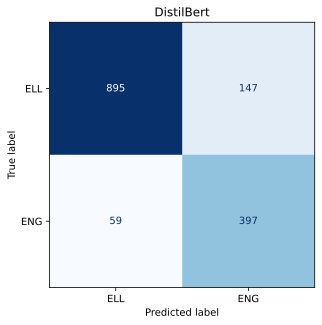

              precision    recall  f1-score   support

         ELL       0.94      0.86      0.90      1042
         ENG       0.73      0.87      0.79       456

    accuracy                           0.86      1498
   macro avg       0.83      0.86      0.85      1498
weighted avg       0.87      0.86      0.87      1498



,precision,recall,f1-score,support,maxlen
ELL,0.938155,0.858925,0.896794,1042.000000,none
ENG,0.729779,0.870614,0.794000,456.000000,none
accuracy,0.862483,0.862483,0.862483,0.862483,none
macro avg,0.833967,0.864770,0.845397,1498.000000,none
weighted avg,0.874724,0.862483,0.865503,1498.000000,none


In [8]:
y_pred = trainer.predict(test_dataset)
y_pred_metrics = y_pred.metrics
print("y_pred_metrics:")
ipy_display(pd.DataFrame(y_pred_metrics, index=[0]))

logs = pd.DataFrame(trainer.state.log_history)
print("Log history:")
ipy_display(logs)

y_preds = np.argmax(y_pred.predictions, axis=1)
y_true = y_test.tolist()

cm = confusion_matrix(y_true, y_preds)
cm_disp = ConfusionMatrixDisplay(cm, display_labels=labels).plot(colorbar=False, cmap='Blues')
plt.title(f"{model.__class__.__name__.removesuffix('ForSequenceClassification')}")
plt.show();

report = classification_report(y_true, y_preds, target_names=labels, output_dict=True)
print(classification_report(y_true, y_preds, target_names=labels))

results = pd.DataFrame(report).transpose()
results['maxlen'] = 'none'
ipy_display(results)

all_results = pd.concat([all_results, results])

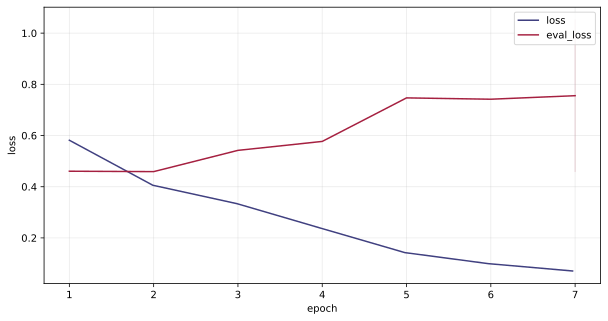

In [9]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 5))

sns.lineplot(data=logs, x='epoch', y='loss', color=COLORS[0], label='loss', zorder=2)
sns.lineplot(data=logs, x='epoch', y='eval_loss', color=COLORS[1], label='eval_loss', zorder=2)

plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid(alpha=0.25, zorder=0)
plt.legend()
plt.show();

In [10]:
# Error analysis

df = pd.DataFrame({'text': X_test.tolist(), 'true': y_true, 'pred': y_preds})
df['correct'] = df['true'] == df['pred']
df['correct'] = df['correct'].map({True: 'correct', False: 'incorrect'})
df['true'] = df['true'].map({0: 'ELL', 1: 'ENG'})
df['pred'] = df['pred'].map({0: 'ELL', 1: 'ENG'})
df

,text,true,pred,correct
0,Although the Greeks call the country Hellas or...,ELL,ELL,correct
1,Finally `` The European Union backed the Greek...,ELL,ELL,correct
2,you are in a shitty situation as we speak.and ...,ELL,ELL,correct
3,It 's not just me that says this . . ( even IM...,ELL,ELL,correct
4,The Greek government has actually given a prop...,ELL,ELL,correct
...,...,...,...,...
1493,0 ) The scary thing to me ( and it should be t...,ENG,ENG,correct
1494,I remember once having discussion with my coll...,ENG,ELL,incorrect
1495,> `` The Russian leadership is clearly fine wi...,ENG,ENG,correct
1496,0 ) The current GOP `` mainstream '' economic ...,ENG,ENG,correct


In [11]:
wrong_preds = df[df['correct'] == 'incorrect'] # only show incorrect predictions
wrong_preds

,text,true,pred,correct
9,Although the International court of justice cl...,ELL,ENG,incorrect
14,You can see how this would lead to more people...,ELL,ENG,incorrect
15,You 're at the point where you ca n't realize ...,ELL,ENG,incorrect
16,> People forced out of homes by the IDF ( rath...,ELL,ENG,incorrect
17,"As for the `` forced dependence , '' i concede...",ELL,ENG,incorrect
...,...,...,...,...
1467,lol Nor did I know you could actually compare ...,ENG,ELL,incorrect
1480,> Adding to the mix of constrained credit cond...,ENG,ELL,incorrect
1483,** Under a similar US-based EU fiscal union **...,ENG,ELL,incorrect
1489,You start to accept them to country = they wil...,ENG,ELL,incorrect
